In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, upsample_2d
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization, batch_normalization
import tensorflow as tf
from scipy import stats
import time
from imp import reload
import pandas as pd
from datetime import timedelta

%matplotlib inline

Importing our own modules:

In [2]:
import read_data
import prep_dat

Setting some of the parameters and directories here:

In [7]:
# data directory
data_path = "/home/ch194765/data/T_Release/"

inputCounter = 0
NumberOfSamples = 14

totalTime = []
borderCheckingSize = 5
totalNumberOfSamples = 5000
inputBatch = np.zeros((NumberOfSamples*124,256,256,1))
inputBatchLabel = np.zeros((NumberOfSamples*124,256,256,2))

# Loading the Data

First, load the unlabeled data with appropriate size ($256\times256$) into the system. Our read_data.enigma_releases() gives out a list of raw images and their corresponding labels.

In [8]:
reload(read_data)
id_loc = [0,4]
raw_dat,_ = read_data.enigma_releases(data_path, id_loc)

# get the dimension of data
height, width, _ = raw_dat[0].shape

# normalizing the data
raw_dat = [prep_dat.normalize_nii(dat) for dat in raw_dat]

ValueError: invalid literal for int() with base 10: 'at10'

(256, 256, 155)

Some frames (slices) of the ENIGMA data have artifacts in them. So we ignore several beginning slices and only consider the remaining ones.

In [295]:
start_frame = 50

# prune the data
raw_dat = [sub_dat[:,:,start_frame:] for sub_dat in raw_dat]

Reshaping the data into 4D tensors with dimensions (batch_size x height x width x 1), where the last dimension corresponds to the number of channels input images have (3 in case of RGB images, 1 in case of our MRI's).

In [296]:
# concatenate everything into one single tensor
all_dat = np.concatenate(raw_dat, axis=2)
dat = np.reshape(all_dat, (1,)+all_dat.shape)
dat = np.swapaxes(dat, 0, 3)

In [300]:
n = dat.shape[0]

# Setting the Network Parameters

In [306]:
# Parameters
batch_size = 50
epochs = 5
learning_rate = 0.01
tf.reset_default_graph()

# input placeholder
x = tf.placeholder(tf.float32, [None, width, height, 1])

# Network's Architecture 

Let's for now try a toy architecture and and see how it works. We will build the following autoencoder to extract some feature vectors. The encoder can have the following structure:

* Input layer, dimension: $1\times256\times 256$ 
* CNN-1, with 4 filters of size $3\times3$ (output: $4\times1256\times256$)
* Max-Pooling with $2\times2$ neighborhood (output: $4\times128\times128$)
* CNN-2, with 8 filters of size $3\times3$ (output: $8\times128\times128$)
* Max-Pooling with $2\times2$ neighborhood (output: $8\times64\times64$)
* CNN-3, with 16 filters of size $3\times3$ (output: $16\times64\times64$)
* Max-Pooling with $2\times2$ neighborhood (output: $16\times32\times32$)
* CNN-4, with 32 filters of size $3\times3$ (output: $32\times32\times32$)
* Max-Pooling with $2\times2$ neighborhood (output: $32\times16\times16$)
* CNN-5, with 64 filters of size $3\times3$ (output: $64\times16\times16$)
* Max-Pooling with $2\times2$ neighborhood (output: $64\times8\times8$)
* CNN-6, with 64 filters of size $3\times3$ (output: $64\times8\times8$)
* Max-Pooling with $2\times2$ neighborhood (output: $64\times4\times4$)
* CNN-7, with 64 filters of size $3\times3$ (output: $64\times4\times4$)
* Max-Pooling with $2\times2$ neighborhood (output: $64\times2\times2$)
* CNN-8, with 64 filters of size $1\times1$ (output: $64\times2\times2$)
* Max-Pooling with $2\times2$ neighborhood (output: $64\times1\times1$)
* CNN-9, with 64 filters of size $1\times1$ (output: $64\times1\times1$)


In [307]:
conv1 = conv_2d(x, 4, 3, activation='relu',padding='same', regularizer="L2")
pool1 = max_pool_2d(conv1, 2)

conv2 = conv_2d(pool1, 8, 3, activation='relu',padding='same', regularizer="L2")
pool2 = max_pool_2d(conv2, 2)

conv3 = conv_2d(pool2, 16, 3, activation='relu',padding='same', regularizer="L2")
pool3 = max_pool_2d(conv3, 2)

conv4 = conv_2d(pool3, 32, 3, activation='relu',padding='same', regularizer="L2")
pool4 = max_pool_2d(conv4, 2)

conv5 = conv_2d(pool4, 64, 3, activation='relu',padding='same', regularizer="L2")
pool5 = max_pool_2d(conv5, 2)

conv6 = conv_2d(pool5, 64, 3, activation='relu',padding='same', regularizer="L2")
pool6 = max_pool_2d(conv6, 2)

conv7 = conv_2d(pool6, 64, 3, activation='relu',padding='same', regularizer="L2")
pool7 = max_pool_2d(conv7, 2)

conv8 = conv_2d(pool7, 64, 1, activation='relu',padding='same', regularizer="L2")
pool8 = max_pool_2d(conv8, 2)

conv9 = conv_2d(pool8, 64, 1, activation='relu',padding='same', regularizer="L2")

# features will be read here

The decoer will have a strucutre symmteric to the encoder:

* Up-sampling with $2\times2$ neighborhood (output: $64\times2\times2$)
* CNN-10, with 64 filters of size $1\times1$ (output: $64\times2\times2$)
* Up-sampling with $2\times2$ neighborhood (output: $64\times4\times4$)
* CNN-11, with 64 filters of size $3\times3$ (output: $64\times4\times4$)
* Up-sampling with $2\times2$ neighborhood (output: $64\times8\times8$)
* CNN-12, with 64 filters of size $3\times3$ (output: $64\times8\times8$)
* Up-sampling with $2\times2$ neighborhood (output: $64\times16\times16$)
* CNN-13, with 64 filters of size $3\times3$ (output: $64\times16\times16$)
* Up-sampling with $2\times2$ neighborhood (output: $64\times32\times32$)
* CNN-14, with 32 filters of size $3\times3$ (output: $32\times32\times32$)
* Up-sampling with $2\times2$ neighborhood (output: $32\times64\times64$)
* CNN-15, with 16 filters of size $3\times3$ (output: $16\times64\times64$)
* Up-sampling with $2\times2$ neighborhood (output: $16\times128\times128$)
* CNN-16, with 8 filters of size $3\times3$ (output: $8\times128\times128$)
* Up-sampling with $2\times2$ neighborhood (output: $8\times256\times256$)
* CNN-17, with 4 filters of size $3\times3$ (output: $4\times256\times256$)

* CNN-18, with 1 filters of size $3\times3$ (output: $1\times256\times256$)

In [308]:
up10 = upsample_2d(conv9,2)
conv10 = conv_2d(up10, 64, 1, activation='relu',padding='same', regularizer="L2")

up11 = upsample_2d(conv10,2)
conv11 = conv_2d(up11, 64, 3, activation='relu',padding='same', regularizer="L2")

up12 = upsample_2d(conv11,2)
conv12 = conv_2d(up12, 64, 3, activation='relu',padding='same', regularizer="L2")

up13 = upsample_2d(conv12,2)
conv13 = conv_2d(up13, 64, 3, activation='relu',padding='same', regularizer="L2")

up14 = upsample_2d(conv13,2)
conv14 = conv_2d(up14, 32, 3, activation='relu',padding='same', regularizer="L2")

up15 = upsample_2d(conv14,2)
conv15 = conv_2d(up15, 16, 3, activation='relu',padding='same', regularizer="L2")

up16 = upsample_2d(conv15,2)
conv16 = conv_2d(up16, 8, 3, activation='relu',padding='same', regularizer="L2")

up17 = upsample_2d(conv16,2)
conv17 = conv_2d(up17, 4, 3, activation='relu',padding='same', regularizer="L2")

# reconstructed image
xhat = conv_2d(conv17, 1, 1, activation='linear',padding='valid')

# Setting the Loss Function and the Optimizer 

Now that the architecure of the network is fixed and the layers are built up, we define the objective function to optimize by specifying the loss function, and the optimization tool to use for optimizing it.

In [322]:
# vectorizing the input and its estimate
vec_x = tf.reshape(x, [batch_size*width*height, 1])
vec_xhat = tf.reshape(xhat, [batch_size*width*height, 1])

# MSE as the loss
loss = tf.reduce_mean(tf.square(vec_x - vec_xhat))

# ADAM as the optimizer
optimizer_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

# Training

First, build batches of data to go through them in every epochL

In [226]:
for i, batches in enumerate(prep_dat.gen_batch_tensors(dat, batch_inds)):
    if np.remainder(i,100)==0:
        print(str(i) + '-' + str(batches.shape))

0-(2, 256, 256, 1)
100-(2, 256, 256, 1)
200-(2, 256, 256, 1)
300-(2, 256, 256, 1)
400-(2, 256, 256, 1)
500-(2, 256, 256, 1)
600-(2, 256, 256, 1)
700-(2, 256, 256, 1)
800-(2, 256, 256, 1)
900-(2, 256, 256, 1)
1000-(2, 256, 256, 1)


Now, we are ready to run and train the autoencoder.

In [323]:
# initialize the variables
init = tf.initialize_all_variables()

#with tf.Session() as sess:
sess.run(init)

for _ in range(epochs):
    # preparing the batch indices
    batch_inds = prep_dat.gen_batch_inds(n, batch_size)

    # going through all the batches
    for i, batch_dat in enumerate(prep_dat.gen_batch_tensors(dat, batch_inds)):
        sess.run(optimizer_step, feed_dict={x: batch_dat})

        if np.remainder(i, 100)==0:
            loss_val = sess.run(loss, feed_dict={x: batch_dat})
            print("loss value in iteration %d: %.2f" % (i, loss_val))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
loss value in iteration 0: 3683.79
loss value in iteration 0: 1283.19
loss value in iteration 0: 1284.05
loss value in iteration 0: 1174.41
loss value in iteration 0: 1310.09


In [324]:
# reconstruction:
sess.run(loss, feed_dict={x: batch_dat})

1117.6417

# Reconstructing an Image

In [344]:
test_image = np.reshape(dat[50], (1,)+dat.shape[1:])
#test_image.shape
pred = sess.run(xhat, feed_dict={x: test_image})
pred = np.squeeze(pred)

(-0.5, 255.5, 255.5, -0.5)

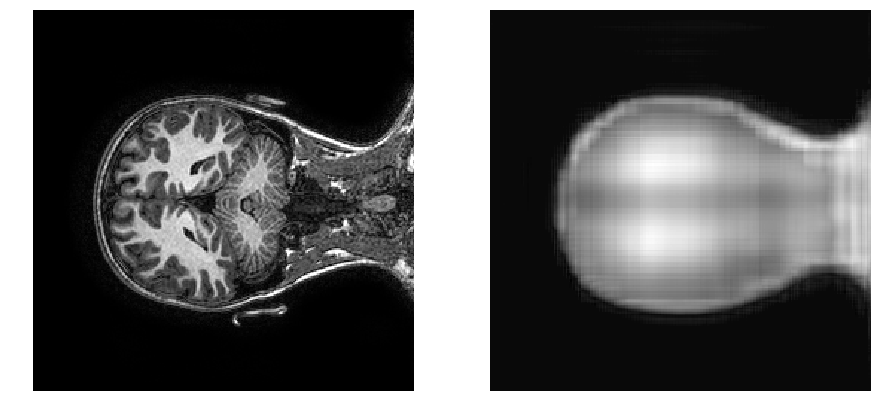

In [345]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))

ax[0].imshow(np.squeeze(test_image), cmap='gray')
ax[0].axis('off')
ax[1].imshow(pred, cmap='gray')
ax[1].axis('off')